In [2]:
%matplotlib inline
import scipy
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np

In [3]:
print(f'scipy: {scipy.__version__}')
print(f'numpy: {np.__version__}')

scipy: 1.2.1
numpy: 1.16.2


## Gamma Distribution

Text(0.5, 0, 'x')

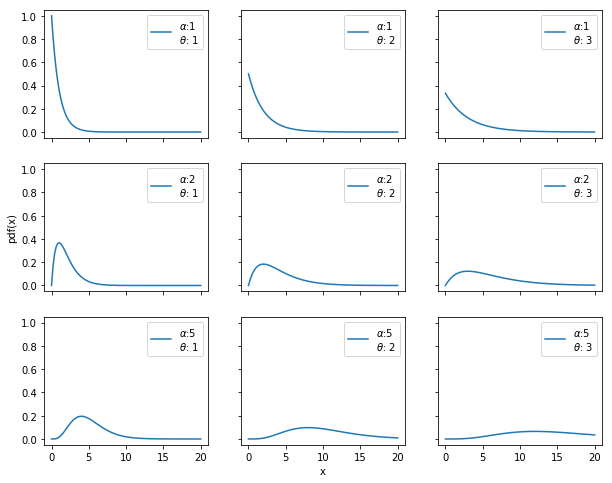

In [10]:
rates = [1,2,5]
scales = [1,2,3]

x = np.linspace(0,20,100)
fig, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True, figsize=(10,8))

for i, r in enumerate(rates):
    for j, s in enumerate(scales):
        rv = stats.gamma(a=r, scale=s)
        ax[i,j].plot(x, rv.pdf(x), label=f'$\\alpha$:{r}\n$\\theta$: {s}')
        ax[i,j].legend()

ax[1,0].set_ylabel('pdf(x)')
ax[2,1].set_xlabel('x')

In [2]:
np.repeat(5,10)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

## Binomial Distribution

In [13]:
n, p = 5, 0.4

mean, var, skew, kurt = stats.binom.stats(n,p, moments='mvsk')
mean, var, skew, kurt

(array(2.), array(1.2), array(0.18257419), array(-0.36666667))

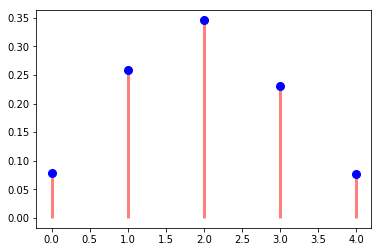

In [26]:
x = np.arange(stats.binom.ppf(0.01,n,p),stats.binom.ppf(0.99,n,p))

plt.plot(x, stats.binom.pmf(x,n,p), 'bo', ms=8)
plt.vlines(x,0, stats.binom.pmf(x,n,p), 'r', lw=3, alpha=0.5)

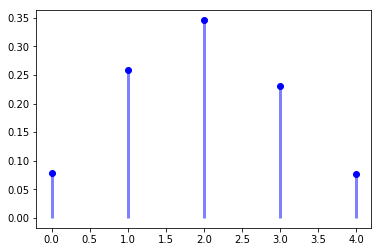

In [25]:
dist = stats.binom(n,p)
plt.plot(x, dist.pmf(x), 'bo')
plt.vlines(x,0, dist.pmf(x), 'b', lw=3, alpha=0.5)